In [2]:
import csv,random,pickle,os,zipfile,string,keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_hub as hub
#########################################################
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
###################################################################
from nltk import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#########################################################
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import TextVectorization
#########################################################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#########################################################
from scipy.stats import linregress
from unidecode import unidecode

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [31]:
cList = {
    "i`m": "i am",
    "you`re": "you are",
    "it`s": "it is",
    "we`re": "we are",
    "we`ll": "we will",
    "That`s": "that is",
    "haven`t": "have not",
    "let`s": "let us",
    "ain`t": "am not / are not / is not / has not / have not",
    "aren`t": "are not / am not",
    "can`t": "cannot",
    "can`t`ve": "cannot have",
    "`cause": "because",
    "could`ve": "could have",
    "couldn`t": "could not",
    "couldn`t`ve": "could not have",
    "didn`t": "did not",
    "doesn`t": "does not",
    "don`t": "do not",
    "hadn`t": "had not",
    "hadn`t`ve": "had not have",
    "hasn`t": "has not",
    "haven`t": "have not",
    "he`d": "he had / he would",
    "he`d`ve": "he would have",
    "he`ll": "he shall / he will",
    "he`ll`ve": "he shall have / he will have",
    "he`s": "he has / he is",
    "how`d": "how did",
    "how`d`y": "how do you",
    "how`ll": "how will",
    "how`s": "how has / how is / how does",
    "I`d": "I had / I would",
    "I`d`ve": "I would have",
    "I`ll": "I shall / I will",
    "I`ll`ve": "I shall have / I will have",
    "I`m": "I am",
    "I`ve": "I have",
    "isn`t": "is not",
    "it`d": "it had / it would",
    "it`d`ve": "it would have",
    "it`ll": "it shall / it will",
    "it`ll`ve": "it shall have / it will have",
    "it`s": "it has / it is",
    "let`s": "let us",
    "ma`am": "madam",
    "mayn`t": "may not",
    "might`ve": "might have",
    "mightn`t": "might not",
    "mightn`t`ve": "might not have",
    "must`ve": "must have",
    "mustn`t": "must not",
    "mustn`t`ve": "must not have",
    "needn`t": "need not",
    "needn`t`ve": "need not have",
    "o`clock": "of the clock",
    "oughtn`t": "ought not",
    "oughtn`t`ve": "ought not have",
    "shan`t": "shall not",
    "sha`n`t": "shall not",
    "shan`t`ve": "shall not have",
    "she`d": "she had / she would",
    "she`d`ve": "she would have",
    "she`ll": "she shall / she will",
    "she`ll`ve": "she shall have / she will have",
    "she`s": "she has / she is",
    "should`ve": "should have",
    "shouldn`t": "should not",
    "shouldn`t`ve": "should not have",
    "so`ve": "so have",
    "so`s": "so as / so is",
    "that`d": "that would / that had",
    "that`d`ve": "that would have",
    "that`s": "that has / that is",
    "there`d": "there had / there would",
    "there`d`ve": "there would have",
    "there`s": "there has / there is",
    "they`d": "they had / they would",
    "they`d`ve": "they would have",
    "they`ll": "they shall / they will",
    "they`ll`ve": "they shall have / they will have",
    "they`re": "they are",
    "they`ve": "they have",
    "to`ve": "to have",
    "wasn`t": "was not",
    "we`d": "we had / we would",
    "we`d`ve": "we would have",
    "we`ll": "we will",
    "we`ll`ve": "we will have",
    "we`re": "we are",
    "we`ve": "we have",
    "weren`t": "were not",
    "what`ll": "what shall / what will",
    "what`ll`ve": "what shall have / what will have",
    "what`re": "what are",
    "what`s": "what has / what is",
    "what`ve": "what have",
    "when`s": "when has / when is",
    "when`ve": "when have",
    "where`d": "where did",
    "where`s": "where has / where is",
    "where`ve": "where have",
    "who`ll": "who shall / who will",
    "who`ll`ve": "who shall have / who will have",
    "who`s": "who has / who is",
    "who`ve": "who have",
    "why`s": "why has / why is",
    "why`ve": "why have",
    "will`ve": "will have",
    "won`t": "will not",
    "won`t`ve": "will not have",
    "would`ve": "would have",
    "wouldn`t": "would not",
    "wouldn`t`ve": "would not have",
    "y`all": "you all",
    "y`all`d": "you all would",
    "y`all`d`ve": "you all would have",
    "y`all`re": "you all are",
    "y`all`ve": "you all have",
    "you`d": "you had / you would",
    "you`d`ve": "you would have",
    "you`ll": "you shall / you will",
    "you`ll`ve": "you shall have / you will have",
    "you`re": "you are",
    "you`ve": "you have"
}

extra_punctuations = ['', '.', '``', '...', '\'s', '--', '-', 'n\'t', '_', '–', '&']
stopword_list = stopwords.words('english') + list(string.punctuation) + extra_punctuations + ['u', 'the', 'us', 'say',
                                                                                              'that', 'he', 'me', 'she',
                                                                                              'get', 'rt', 'it', 'mt',
                                                                                              'via', 'not', 'and',
                                                                                              'let', 'so', 'say',
                                                                                              'dont', 'use', 'you',
                                                                                              'null']
import regex as re

c_re = re.compile('(%s)' % '|'.join(cList.keys()))


def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]

    return c_re.sub(replace, text)


def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_punctuations(data):
    punct_tag = re.compile(r'[^\w\s]')
    data = punct_tag.sub(r'', data)
    return data


def removeSpecialChars(data):
    '''
    Removes special characters which are specifically found in tweets.
    '''
    # Converts HTML tags to the characters they represent
    # soup = BeautifulSoup(data, "html.parser")
    # data = soup.get_text()

    # Convert www.* or https?://* to empty strings
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', data)

    # Convert @username to empty strings
    data = re.sub('@[^\s]+', '', data)

    # remove org.apache. like texts
    data = re.sub('(\w+\.){2,}', '', data)

    # Remove additional white spaces
    data = re.sub('[\s]+', ' ', data)

    data = re.sub('\.(?!$)', '', data)

    # Replace #word with word
    data = re.sub(r'#([^\s]+)', r'\1', data)

    return data


def remove_nonenglish_charac(string):
    return re.sub('[^a-zA-Z]', ' ', string)


def text_cleaning(data):
    """Text Cleaning
    let us clean the dataset and remove the redundancies.This includes

    HTML codes
    URLs
    Emojis
    Stopwords
    Punctuations
    Expanding Abbreviations"""

    # wordnet_lemmatizer = WordNetLemmatizer()
    # stemmer = PorterStemmer()
    try:
        data = unidecode(data)
    except Exception as ex:
        print(f"#### the data is : " , data)
        raise ex
    data = expandContractions(data)
    # tokens = word_tokenize(data)
    # data = ' '.join([tok for tok in tokens if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()])
    data = re.sub('\b\w{,2}\b', '', data)
    data = re.sub(' +', ' ', data)
    data = removeSpecialChars(data)
    data = remove_emoji(data)
    # data = [stemmer.stem(w) for w in data.split()]
    # data = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in data])
    return data


def step_1_get_dataframe(filename, filetype="json",encoding=None):
    if filetype == "csv":
        train_df = pd.read_csv(filename,encoding=encoding)
    if filetype == "json":
        train_df = pd.read_json(filename,encoding=encoding)
    train_df.drop_duplicates(keep='first').count()
    train_df = train_df.dropna()
    train_df_shuffled = train_df.sample(frac=1, random_state=42)  # shuffle with random_state=42 for reproducibility
    print(train_df_shuffled.head())
    print(train_df_shuffled.columns)
    return train_df_shuffled


def remove_columns(df, cols: list, ):
    df.drop(cols, axis=1, inplace=True)
    print(df.head)
    print(df.columns)
    return df


def rename_column(df,original, new, ):
    df.rename({original: new}, axis=1, inplace=True)
    print(df.columns)
    return df


def label_count_rebalancing(df,labels):
    dataframes = []
    print("### Old count: ")
    print(df.labels.value_counts())
    for label in labels:
        dataframes.append(df[df['labels'] == label])

    lowest = 9999999999
    for df in dataframes:
        if len(df) < lowest:
            lowest = len(df)

    balanced_df = []
    for df in dataframes:
        balanced_df.append(
            resample(df, replace=False, n_samples=lowest)
        )

    train_df = pd.concat(balanced_df)
    print(f"### New counts ")
    print(train_df.labels.value_counts())
    return train_df.sample(frac=1, random_state=42)


def unzip_data(filename):
    """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
    if os.path.exists(filename):
        zip_ref = zipfile.ZipFile(filename, "r")
        zip_ref.extractall()
        zip_ref.close()
        os.remove(filename)
    else:
        print(f"File not found")


def apply_text_cleaning(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: text_cleaning(x))
    return df


In [52]:
train_df = step_1_get_dataframe("TheSocialDilemma.csv","csv")

            user_name           user_location  \
4442      Lauren Gray           Knoxville, TN   
10246   Peony Hirwani           Indore, India   
8515      Masoom Jain        Bengaluru, India   
5841          Lynette                 England   
6067   |FINESSE KING|  |Detroit ↔️ Ypsilanti|   

                                        user_description         user_created  \
4442   Always #multitasking. @cityofoakridge communic...  2012-05-24 23:36:31   
10246  I am a journalist who writes for The @Independ...  2016-04-30 12:17:20   
8515   Product & Operations @Abaqus. Building @TEmpat...  2010-07-28 07:20:18   
5841   GP. Interested in barbell training, books, get...  2013-01-17 13:01:39   
6067   Funny retweets, constructive criticism, Black ...  2011-08-16 04:06:11   

       user_followers  user_friends  user_favourites  user_verified  \
4442             1090           906            13332           True   
10246              75            96              343          False   
8515 

In [53]:
train_df = apply_text_cleaning(train_df,"text")

In [54]:
train_df = rename_column(train_df,"Sentiment","labels")

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'labels'],
      dtype='object')


In [55]:
train_df = label_count_rebalancing(train_df,["Neutral","Positive","Negative"])

### Old count: 
labels
Positive    5190
Neutral     4608
Negative    1935
Name: count, dtype: int64
### New counts 
labels
Neutral     1935
Positive    1935
Negative    1935
Name: count, dtype: int64


In [56]:
sentences = train_df["text"].values
labels = train_df["labels"].values

In [57]:
from sklearn.model_selection import train_test_split
train_text, val_text, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.20, random_state=42)

In [58]:
label_encoder = LabelEncoder()

train_sentences = train_text
train_labels = label_encoder.fit_transform(train_labels)

validation_sentences = val_text
validation_labels = label_encoder.fit_transform(val_labels)


In [59]:
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(validation_sentences)} sentences for validation.\n")
print(f"There are {len(validation_labels)} labels for validation.")

There are 4644 sentences for training.

There are 4644 labels for training.

There are 1161 sentences for validation.

There are 1161 labels for validation.


In [60]:
tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(train_sentences)

In [61]:
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)
VOCAB_SIZE

5918

In [63]:
train_seqs = tokenizer.texts_to_sequences(train_sentences)
val_seqs = tokenizer.texts_to_sequences(validation_sentences)

In [64]:
train_pad_sqs = pad_sequences(train_seqs,maxlen=30,padding="post",truncating="post")
val_pad_seqs = pad_sequences(val_seqs,maxlen=30,padding="post",truncating="post")

In [78]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=100,input_length=30),
        tf.keras.layers.LSTM(64,return_sequences=True, dropout=.5),
        tf.keras.layers.LSTM(32, dropout=.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ]
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [79]:
history = model.fit(train_pad_sqs,train_labels,epochs=15, validation_data=(val_pad_seqs, validation_labels))

Epoch 1/15


2023-09-30 14:12:08.865338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:09.077701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:09.178229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:09.447201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:09.615142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.4022

2023-09-30 14:12:15.048434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:15.133130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 14:12:15.203621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 8s 41ms/step - loss: 1.0764 - accuracy: 0.4022 - val_loss: 0.9735 - val_accuracy: 0.4849
Epoch 2/15
146/146 [==============================] - 4s 27ms/step - loss: 0.8934 - accuracy: 0.5448 - val_loss: 0.8030 - val_accuracy: 0.6133
Epoch 3/15
146/146 [==============================] - 3s 24ms/step - loss: 0.6501 - accuracy: 0.7209 - val_loss: 0.6659 - val_accuracy: 0.7373
Epoch 4/15
146/146 [==============================] - 3s 24ms/step - loss: 0.4355 - accuracy: 0.8549 - val_loss: 0.5500 - val_accuracy: 0.7812
Epoch 5/15
146/146 [==============================] - 3s 24ms/step - loss: 0.3054 - accuracy: 0.9152 - val_loss: 0.5432 - val_accuracy: 0.8346
Epoch 6/15
146/146 [==============================] - 3s 23ms/step - loss: 0.2229 - accuracy: 0.9423 - val_loss: 0.5048 - val_accuracy: 0.8441
Epoch 7/15
146/146 [==============================] - 3s 23ms/step - loss: 0.1763 - accuracy: 0.9552 - val_loss: 0.5047 - val_accuracy: 0.8407
Epoch 8/15

In [99]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=100,input_length=30),
        tf.keras.layers.LSTM(64,return_sequences=True, dropout=.2),
        tf.keras.layers.LSTM(32, dropout=.2),
        tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ]
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history = model.fit(train_pad_sqs,train_labels,epochs=30, validation_data=(val_pad_seqs, validation_labels))

Epoch 1/30


2023-09-30 15:04:24.243349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:24.491489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:24.630689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:24.855322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:25.067247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.4550

2023-09-30 15:04:31.908313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:32.003818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 15:04:32.101186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 10s 53ms/step - loss: 1.1213 - accuracy: 0.4550 - val_loss: 0.9219 - val_accuracy: 0.5271
Epoch 2/30
146/146 [==============================] - 5s 35ms/step - loss: 0.7801 - accuracy: 0.6221 - val_loss: 0.7681 - val_accuracy: 0.6124
Epoch 3/30
146/146 [==============================] - 5s 34ms/step - loss: 0.6160 - accuracy: 0.6985 - val_loss: 0.7402 - val_accuracy: 0.6960
Epoch 4/30
146/146 [==============================] - 5s 31ms/step - loss: 0.5395 - accuracy: 0.7791 - val_loss: 0.8310 - val_accuracy: 0.6925
Epoch 5/30
146/146 [==============================] - 5s 32ms/step - loss: 0.4781 - accuracy: 0.8144 - val_loss: 0.7173 - val_accuracy: 0.7140
Epoch 6/30
146/146 [==============================] - 5s 31ms/step - loss: 0.3840 - accuracy: 0.8725 - val_loss: 0.6161 - val_accuracy: 0.7778
Epoch 7/30
146/146 [==============================] - 4s 30ms/step - loss: 0.3344 - accuracy: 0.9029 - val_loss: 0.5946 - val_accuracy: 0.8079
Epoch 8/3

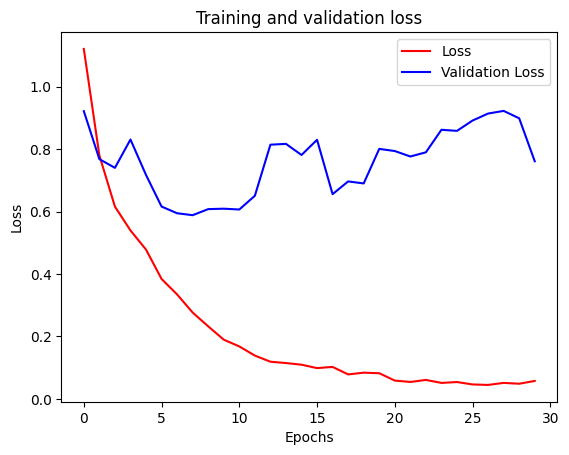

In [100]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(30)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [101]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Test the slope of your val_loss curve. val_loss curve should be 0.0005 at maximum.
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is 0.00588
